In [1]:
col_names = []

with open('cols.txt','r') as f:
    for line in f:
        for word in line.split():
           col_names.append(word)

print(len(col_names))

95


In [2]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

type_list = [StructField('date', StringType(), True),
             StructField('serial_number', StringType(), True),
             StructField('model', StringType(), True),
             StructField('capacity_bytes', DoubleType(), True),
             StructField('failure', DoubleType(), True)]

for i in range(5, len(col_names)):
    type_list.append(StructField(col_names[i], DoubleType(), True))


schema = StructType(type_list)

# https://www.kaggle.com/backblaze/hard-drive-test-data
df = sqlContext.read.format('csv').load('E:/ws/harddrive.csv', header = True, nullValue = 'NA',  schema = schema, sep = ',')

# drop normalized 
df = df.select([column for column in df.columns if 'normalized' not in column])

print(df.count())

3179295


In [3]:
from pyspark.sql.functions import count
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col


# broj diskova za svaki model
df.groupBy('model').agg(count('*').alias('number_of_records'), countDistinct('serial_number').alias('number_of_unique_disks')) \
                   .orderBy('number_of_unique_disks', ascending = False) \
                   .toPandas() \
                   .head(30) 


,model,number_of_records,number_of_unique_disks
0,ST4000DM000,1681473,35057
1,HGST HMS5C4040ALE640,368077,7085
2,HGST HMS5C4040BLE640,186832,4892
3,Hitachi HDS5C3030ALA630,236690,4563
4,Hitachi HDS722020ALA330,224052,4502
5,Hitachi HDS5C4040ALE630,136969,2639
6,ST6000DX000,97864,1885
7,WDC WD30EFRX,54686,1073
8,Hitachi HDS723030ALA640,51940,1000
9,ST500LM012 HN,31412,703


In [5]:
# otkazi po modelu
df.groupBy('model').sum('failure') \
                   .select('model', col('sum(failure)').alias('failure_cnt')) \
                   .orderBy('failure_cnt', ascending = False) \
                   .toPandas() \
                   .head(30)

,model,failure_cnt
0,ST4000DM000,139.0
1,ST320LT007,15.0
2,Hitachi HDS722020ALA330,13.0
3,WDC WD800AAJS,6.0
4,WDC WD30EFRX,6.0
5,Hitachi HDS5C3030ALA630,5.0
6,Hitachi HDS5C4040ALE630,4.0
7,WDC WD20EFRX,3.0
8,HGST HMS5C4040ALE640,2.0
9,WDC WD1600AAJB,2.0


In [5]:
# izdvajanje NULL kolona
df = df.where(df.model == 'ST4000DM000')


number_of_records = df.count()
null_columns_dict = {}
print('No. of records: ', number_of_records)
for i in range(5, len(col_names)):
    if 'normalized' not in col_names[i]: # already removed
        temp = df.where(col(col_names[i]).isNull()).count()
        null_columns_dict[col_names[i]] = temp
        print(col_names[i], ' is null in ', temp, ' rows')

No. of records:  1681473
smart_1_raw  is null in  0  rows
smart_2_raw  is null in  1681473  rows
smart_3_raw  is null in  0  rows
smart_4_raw  is null in  0  rows
smart_5_raw  is null in  0  rows
smart_7_raw  is null in  0  rows
smart_8_raw  is null in  1681473  rows
smart_9_raw  is null in  0  rows
smart_10_raw  is null in  0  rows
smart_11_raw  is null in  1681473  rows
smart_12_raw  is null in  0  rows
smart_13_raw  is null in  1681473  rows
smart_15_raw  is null in  1681473  rows
smart_22_raw  is null in  1681473  rows
smart_183_raw  is null in  0  rows
smart_184_raw  is null in  0  rows
smart_187_raw  is null in  0  rows
smart_188_raw  is null in  0  rows
smart_189_raw  is null in  0  rows
smart_190_raw  is null in  0  rows
smart_191_raw  is null in  0  rows
smart_192_raw  is null in  0  rows
smart_193_raw  is null in  0  rows
smart_194_raw  is null in  0  rows
smart_195_raw  is null in  1681473  rows
smart_196_raw  is null in  1681473  rows
smart_197_raw  is null in  0  rows
smar

In [52]:
# s.m.a.r.t kolone koje imaju null vrednosti u svim redovima za ST4000DM000 hdd
null_columns_dict['failure'] = 0 # label
df_new = df.select([key for key, value in null_columns_dict.items() if value != number_of_records])

0


In [3]:
# hardocoded ćelija - lista select_cols dobijena na osnovu rezultate predhodne dve ćelije

select_cols = ['smart_1_raw', 'smart_3_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw', 'smart_10_raw',
               'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw', 'smart_188_raw', 'smart_189_raw',
               'smart_190_raw', 'smart_191_raw', 'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw',
               'smart_198_raw', 'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'failure']

select_cols.insert(0, 'date')
select_cols.insert(0, 'serial_number')
select_cols.insert(0, 'model')

df = df.where(df.model == 'ST4000DM000')
df_new = df.select(select_cols)

In [4]:
# izbacivanje duplikata
print('Failure number before drop: ', df_new.where(df_new.failure == 1.0).count())
df_new = df_new.dropDuplicates() 
print('Failure number after drop: ', df_new.where(df_new.failure == 1.0).count()) 

Failure number before drop:  139
Failure number after drop:  131


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

sample_data = df_new.sample(False, 1.0).toPandas() # > 4 GB RAM 
sample_data['date_time'] = pd.to_datetime(sample_data['date'])
sample_data['day'] = sample_data['date_time'].dt.dayofyear
sample_data.head(2)

,model,serial_number,date,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,...,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,failure,date_time,day
0,ST4000DM000,S301NGZM,2016-01-01,37259224.0,0.0,5.0,0.0,3.348167e-316,1539.0,0.0,...,27.0,0.0,0.0,0.0,7.233121e-321,5.364457e-314,3.365761e-315,0.0,2016-01-01,1
1,ST4000DM000,S301NYEV,2016-01-01,67166616.0,0.0,9.0,0.0,1.625173e-317,694.0,0.0,...,29.0,0.0,0.0,0.0,2.430803e-321,4.493596e-315,1.318849e-315,0.0,2016-01-01,1


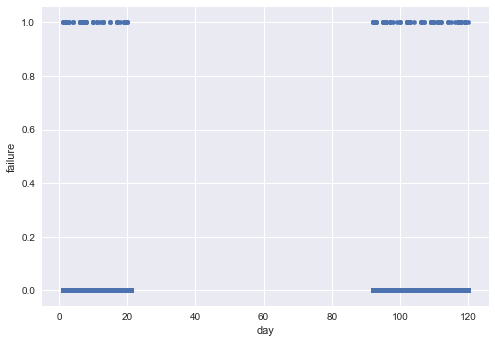

In [10]:
# otkazi ne smeju da budu koncentrisani u istom danu !

sample_data.plot(kind = 'scatter', x = 'day', y = 'failure')
plt.show()

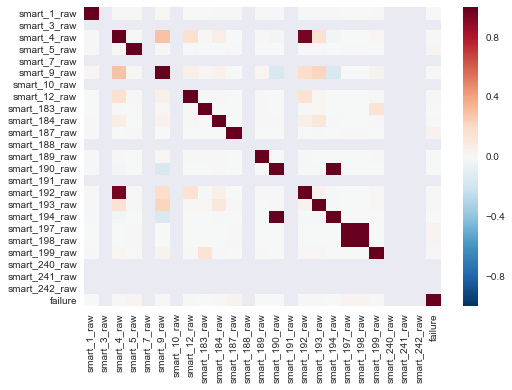

In [11]:
sample_data.drop(['model', 'serial_number', 'date', 'date_time', 'day'], 1, inplace = True)
corr = sample_data.corr()
sb.heatmap(corr)
plt.show()

In [18]:
# import objgraph
# objgraph.show_refs([sample_data], filename = 'sample_graph.png')

# oslobodi memoriju
import gc
del corr
del plt
del sb
del sample_data
gc.collect()


4683

In [5]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer

names_for_assembler = df_new.columns 

# drop label and correlated features
names_for_assembler.remove('failure')
names_for_assembler.remove('smart_192_raw')
names_for_assembler.remove('smart_194_raw')
names_for_assembler.remove('smart_198_raw')
# drop uselles
names_for_assembler.remove('model')
names_for_assembler.remove('serial_number')
names_for_assembler.remove('date')

assembler = VectorAssembler(inputCols = names_for_assembler, outputCol = 'features')
normalizer = Normalizer(inputCol = 'features', outputCol = 'features_norm', p = 1.0)
print(len(names_for_assembler))

21


In [25]:
df_200zs = df_new.sampleBy('failure', fractions = {0.0: 0.000124, 1.0: 1.0}, seed = 43)

print('200~ 0.0 samples | ''1.0: ', df_200zs.where(df_200zs.failure == 1.0).count(), \
                     ' | ' '0.0: ', df_200zs.where(df_200zs.failure == 0.0).count())

200~ 0.0 samples | 1.0:  131  | 0.0:  194


In [79]:
df_500zs = df_new.sampleBy('failure', fractions = {0.0: 500/1617589, 1.0: 1.0}, seed = 43)

print('500~ 0.0 samples | ''1.0: ', df_500zs.where(df_500zs.failure == 1.0).count(), \
                     ' | ' '0.0: ', df_500zs.where(df_500zs.failure == 0.0).count())

500~ 0.0 samples | 1.0:  131  | 0.0:  509


In [17]:
df_1000zs = df_new.sampleBy('failure', fractions = {0.0: 1000/1617589, 1.0: 1.0}, seed = 43)

print('1000~ 0.0 samples | ''1.0: ', df_1000zs.where(df_1000zs.failure == 1.0).count(), \
                     ' | ' '0.0: ', df_1000zs.where(df_1000zs.failure == 0.0).count())

1000~ 0.0 samples | 1.0:  131  | 0.0:  996


In [20]:
df_2000zs = df_new.sampleBy('failure', fractions = {0.0: 2000/1617589, 1.0: 1.0}, seed = 43)

print('2000~ 0.0 samples | ''1.0: ', df_2000zs.where(df_2000zs.failure == 1.0).count(), \
                     ' | ' '0.0: ', df_2000zs.where(df_2000zs.failure == 0.0).count())

2000~ 0.0 samples | 1.0:  131  | 0.0:  1988


In [22]:
df_5000zs = df_new.sampleBy('failure', fractions = {0.0: 5000/1617589, 1.0: 1.0}, seed = 43)

print('5000~ 0.0 samples | ''1.0: ', df_5000zs.where(df_5000zs.failure == 1.0).count(), \
                     ' | ' '0.0: ', df_5000zs.where(df_5000zs.failure == 0.0).count())

5000~ 0.0 samples | 1.0:  131  | 0.0:  4971


In [37]:
df_10000zs = df_new.sampleBy('failure', fractions = {0.0: 10000/1617589, 1.0: 1.0}, seed = 43)

print('10000~ 0.0 samples | ''1.0: ', df_10000zs.where(df_10000zs.failure == 1.0).count(), \
                     ' | ' '0.0: ', df_10000zs.where(df_10000zs.failure == 0.0).count())

10000~ 0.0 samples | 1.0:  131  | 0.0:  9976


In [43]:
df_30000zs = df_new.sampleBy('failure', fractions = {0.0: 30000/1617589, 1.0: 1.0}, seed = 43)

print('30000~ 0.0 samples | ''1.0: ', df_30000zs.where(df_30000zs.failure == 1.0).count(), \
                     ' | ' '0.0: ', df_30000zs.where(df_30000zs.failure == 0.0).count())

30000~ 0.0 samples | 1.0:  131  | 0.0:  29929


In [52]:
df_80000zs = df_new.sampleBy('failure', fractions = {0.0: 80000/1617589, 1.0: 1.0}, seed = 43)

print('80000~ 0.0 samples | ''1.0: ', df_80000zs.where(df_80000zs.failure == 1.0).count(), \
                     ' | ' '0.0: ', df_80000zs.where(df_80000zs.failure == 0.0).count())

80000~ 0.0 samples | 1.0:  131  | 0.0:  79836


In [87]:
df_120000zs = df_new.sampleBy('failure', fractions = {0.0: 120000/1617589, 1.0: 1.0}, seed = 43)

print('120000~ 0.0 samples | ''1.0: ', df_120000zs.where(df_120000zs.failure == 1.0).count(), \
                     ' | ' '0.0: ', df_120000zs.where(df_120000zs.failure == 0.0).count())

120000~ 0.0 samples | 1.0:  131  | 0.0:  119896


In [88]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC


#(train, test) = df_200zs.randomSplit([0.75, 0.25])
#(train, test) = df_500zs.randomSplit([0.75, 0.25])
#(train, test) = df_1000zs.randomSplit([0.75, 0.25])
#(train, test) = df_2000zs.randomSplit([0.75, 0.25])
#(train, test) = df_5000zs.randomSplit([0.75, 0.25])
#(train, test) = df_10000zs.randomSplit([0.75, 0.25])
#(train, test) = df_30000zs.randomSplit([0.75, 0.25])
#(train, test) = df_80000zs.randomSplit([0.75, 0.25])
(train, test) = df_120000zs.randomSplit([0.75, 0.25])

nr_of_failed = test.where(test.failure == 1.0).count()
test_size = test.count()

train.cache()
print(test_size)
print(nr_of_failed)

30014
35


In [89]:
#classifier = RandomForestClassifier(labelCol = 'failure', featuresCol = 'features_norm')
classifier = DecisionTreeClassifier(labelCol = 'failure', featuresCol = 'features_norm')
#classifier = GBTClassifier(labelCol = 'failure', featuresCol = 'features_norm')
#classifier = LinearSVC(labelCol = 'failure', featuresCol = 'features_norm')


pipeline = Pipeline(stages = [assembler, normalizer, classifier])

model = pipeline.fit(train)
#train.unpersist()

from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol = 'failure')

check = predictions.where(predictions.prediction == predictions.failure).count() / test_size
print('Raw accuracy: ', check)

failed = predictions.where(predictions.failure == 1.0)
failures_predicted = failed.where(failed.failure == failed.prediction).count() / nr_of_failed
        
print("Failures predicted: ", failures_predicted)

auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
print("The AUROC is %s and the AUPR is %s." % (auroc, aupr))

Raw accuracy:  0.9990004664489904
Failures predicted:  0.34285714285714286
The AUROC is 0.14629859949583757 and the AUPR is 0.14344216281891217.


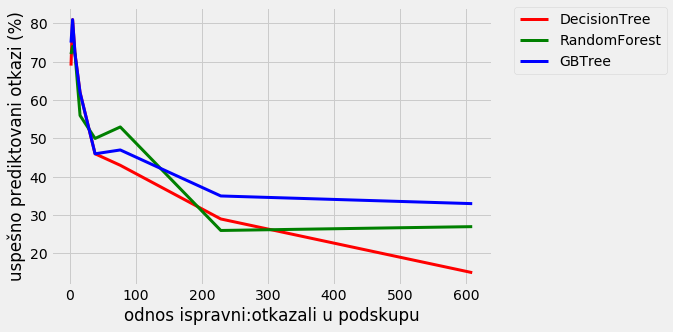

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')

fig = plt.gcf()
fig.set_size_inches(15.5, 10.5)

xs = np.array([194 / 131, 509 / 131, 996 / 131, 1988 / 131, 4971 / 131, 9976 / 131, 29929 / 131, 79836 / 131])
dt_FP = np.array([0.69, 0.81, 0.72, 0.62, 0.46, 0.43, 0.29, 0.15]) * 100
rf_FP = np.array([0.72, 0.74, 0.72, 0.56, 0.50, 0.53, 0.26, 0.27]) * 100
gbt_FP = np.array([0.75, 0.81, 0.72, 0.62, 0.46, 0.47, 0.35, 0.33]) * 100

plt.subplot(223)
dt_line_fp = plt.plot(xs, dt_FP, color = 'red', linewidth = 3, label = 'DecisionTree')
rf_line_fp = plt.plot(xs, rf_FP, color = 'green', linewidth = 3, label = 'RandomForest')
gbt_line_fp = plt.plot(xs, gbt_FP, color = 'blue', linewidth = 3, label = 'GBTree')

# first_legend = plt.legend(handles = [dt_line_fp])
# second_legend = plt.legend(handles = [dt_line_fp])
# second_legend = plt.legend(handles = [dt_line_fp])
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.xlabel('odnos ispravni:otkazali u podskupu')
plt.ylabel('uspešno prediktovani otkazi (%)')
plt.show()